# Intro to TensorFlow: Classify images of clothing

In [59]:
# import Tensorflow
import tensorflow as tf

# import the other helper libraries required
import numpy as np
import keras
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD

## Import the Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and [load the Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directly from TensorFlow:

In [60]:
#complete the code below:
fashion_mnist = tf.keras.datasets.fashion_mnist

#load the data into train_images, train_labels, test_images, test_labels
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Loading the dataset returns four NumPy arrays:

* The `train_images` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `test_images`, and `test_labels` arrays.

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The *labels* are an array of integers, ranging from 0 to 9. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [61]:
#store the class names in a list
#complete the code below
class_names = ['T-shirt/top', 'Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
label_names = range(10)
class_df = pd.DataFrame(
    {'Label': label_names,
     'Class': class_names,
    })

## Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, with each image represented as 28 x 28 pixels:

In [62]:
#check the dimensions of the training data

train_images.shape

(60000, 28, 28)

Likewise, there are 60,000 labels in the training set:

In [63]:
#verify the number of train_lables

train_labels.shape

(60000,)

There are 10,000 images in the test set. Again, each image is represented as 28 x 28 pixels:

In [64]:
#verify the number of images in test_images by checking the dimensions

test_images.shape

(10000, 28, 28)

And the test set contains 10,000 images labels:

In [65]:
#verify the number of images in test_labels

test_labels.shape

(10000,)

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

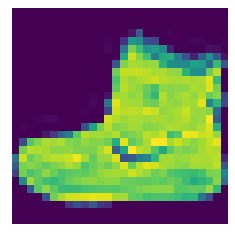

In [66]:
#plot a figure using the imshow() function to view the first image in train_images (train_images[0])

plt.imshow(train_images[0])
plt.yticks([])
plt.xticks([])
plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the *training set* and the *testing set* be preprocessed in the same way:

In [67]:
#complete the code below
train_images = train_images / 255.0
test_images = test_images / 255.0

To verify that the data is in the correct format and that you're ready to build and train the network, display the first 25 images from the *training set* and display the class name below each image.

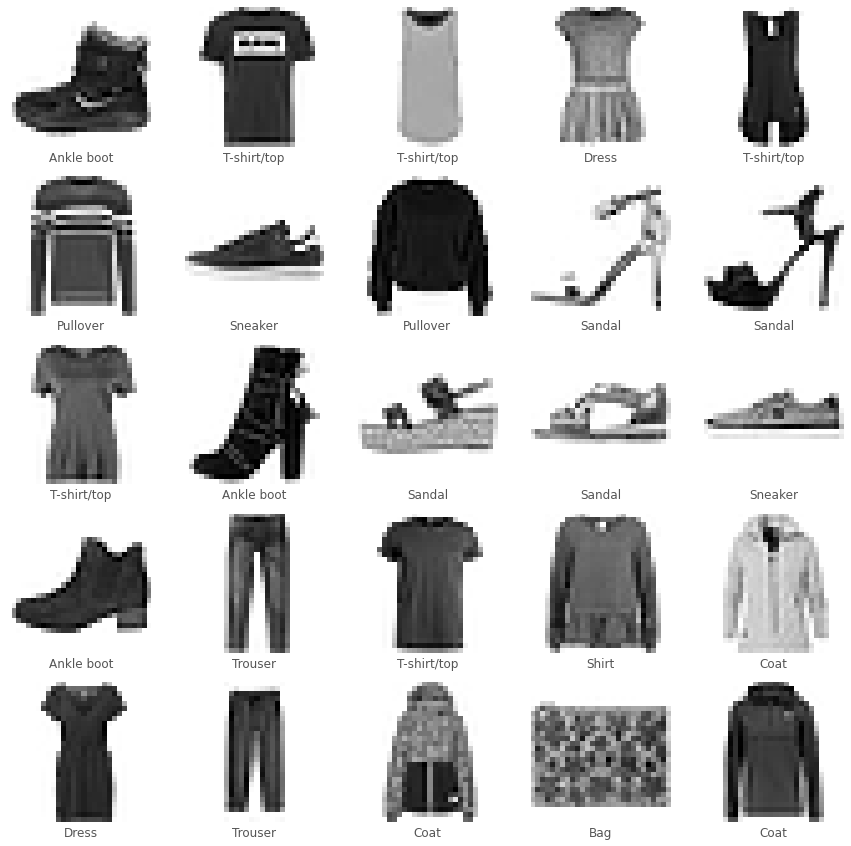

In [68]:
#write code below
fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 5
a=0
for i in range(1, columns*rows+1):
    img=train_images[a]
    name=class_df.at[train_labels[a], "Class"]
    fig.add_subplot(rows, columns, i)
    plt.yticks([])
    plt.xticks([])
    plt.xlabel(name)
    plt.imshow(img, cmap=plt.cm.binary)
    a+=1

plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up the layers

The basic building block of a neural network is the [*layer*](https://www.tensorflow.org/api_docs/python/tf/keras/layers). Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.

In [69]:
#create a model having the layers defined below this cell

model = Sequential()
model.add(Flatten())
model.add(Dense(128, input_dim=784, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(10, activation="softmax"))

The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers with a 'BatchNormalization()' layer in between the 2 dense layers. These are densely connected, or fully connected, neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer returns a logits array with length of 10. Each node contains a score that indicates the current image belongs to one of the 10 classes. 
The Batch Normalization layer works by performing a series of operations on the incoming input data. The set of operations involves standardization, normalization, rescaling and shifting of offset of input values coming into the BN layer.

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's [*compile*](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) step:

* [*Loss function*](https://www.tensorflow.org/api_docs/python/tf/keras/losses) —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* [*Optimizer*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) —This is how the model is updated based on the data it sees and its loss function.
* [*Metrics*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [70]:
#compile the model using model.compile using the adam optimizer, SparseCategoricalCrossentropy loss and accuracy as metrics

model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

## Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model. In this example, the training data is in the `train_images` and `train_labels` arrays.
2. The model learns to associate images and labels.
3. You ask the model to make predictions about a test set—in this example, the `test_images` array.
4. Verify that the predictions match the labels from the `test_labels` array.


### Feed the model

To start training,  call the [`model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method—so called because it "fits" the model to the training data:

In [71]:
#write code below setting epochs=10:

model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.4866 - accuracy: 0.8293
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3955 - accuracy: 0.8601
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3707 - accuracy: 0.8668
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3568 - accuracy: 0.8716
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3420 - accuracy: 0.8759
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3287 - accuracy: 0.8800
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3194 - accuracy: 0.8833
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3098 - accuracy: 0.8878
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3024 - accuracy: 0.8894
Epoch 10/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.297

As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.91 (or 91%) on the training data.

### Evaluate accuracy

Next, compare how the model performs on the test dataset using model.evaluate():

In [72]:
#complete code below

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.3531 - accuracy: 0.8732

Test accuracy: 0.873199999332428


It turns out that the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents *overfitting*. Overfitting happens when a machine learning model performs worse on new, previously unseen inputs than it does on the training data. An overfitted model "memorizes" the noise and details in the training dataset to a point where it negatively impacts the performance of the model on the new data. For more information, see the following:
*   [Demonstrate overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#demonstrate_overfitting)
*   [Strategies to prevent overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting)

### Make predictions

With the model trained, you can use it to make predictions about some images.
The model's linear outputs, [logits](https://developers.google.com/machine-learning/glossary#logits). Attach a softmax layer to convert the logits to probabilities, which are easier to interpret. 

In [73]:
#complete code below
probability_model = Sequential([model, tf.keras.layers.Softmax()])

In [74]:
#predict on the test_images using the probability_model
predictions = probability_model.predict(test_images)

Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [75]:
predictions[0]

array([0.08584417, 0.08583736, 0.08584029, 0.08583969, 0.08583851,
       0.08802835, 0.08586968, 0.08718835, 0.08583744, 0.22387615],
      dtype=float32)

A prediction is an array of 10 numbers. They represent the model's "confidence" that the image corresponds to each of the 10 different articles of clothing. You can see which label has the highest confidence value:

In [76]:
#use np.argmax to find the highest confidence value
arg = np.argmax(predictions, axis=1)
np.argmax(predictions[0])

9

So, the model is most confident that this image is an ankle boot, or `class_names[9]`. Examining the test label shows that this classification is correct:

In [77]:
test_labels[0]

9

### Verify predictions

With the model trained, you can use it to make predictions about some images.

Let's look at the 0th image, predictions, and prediction array. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.
Plot should look like this:
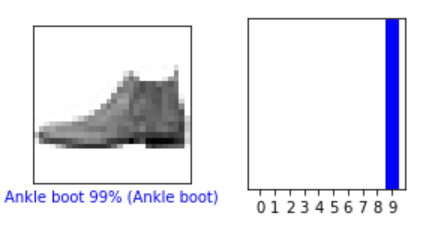

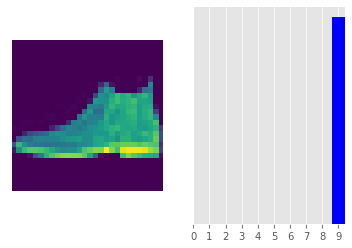

In [78]:
#plot the 0th image and next to that plot a bar graph of the predicted values for that image
#  if predicted_label is the same as the actual label of the image then the x_axis label should be in blue, whereas 
# if the predicted_label is not the same as the actual label of the image then the x_axis label should be in red
plt.subplot(1,2,1)
plt.imshow(test_images[0])
plt.yticks([])
plt.xticks([])
plt.subplot(1,2,2)
if arg[0] == test_labels[0]:
  plt.bar(range(arg[0],arg[0]+1), arg[0], color='blue')
  plt.yticks([])
  plt.xticks(range(10))
else:
  plt.bar(range(arg[0],arg[0]+1), arg[0], color='red')
  plt.yticks([])
  plt.xticks(range(10))
plt.show()

Similarly plot the image and predicted values for another value in the test_images

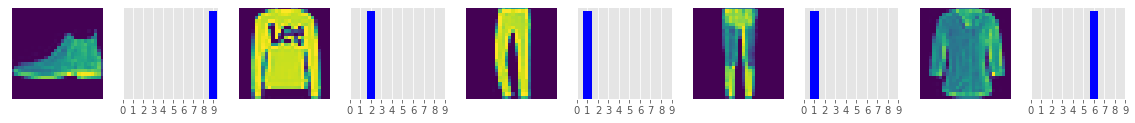

In [79]:
#write code below
fig = plt.figure(figsize=(20,20))
rows = 10
columns = 10
a = 1
for i in range(5):
  fig.add_subplot(rows, columns,a)
  plt.imshow(test_images[i])
  plt.yticks([])
  plt.xticks([])
  a += 1
  fig.add_subplot(rows, columns,a)
  if arg[i] == test_labels[i]:
    plt.bar(range(test_labels[i], test_labels[i]+1), 1, color='blue')
    plt.yticks([])
    plt.xticks(range(10))
  else:
    plt.bar(range(test_labels[i], test_labels[i]+1), 1, color='red')
    plt.yticks([])
    plt.xticks(range(10))
  a += 1
plt.show()

plot several images with their predictions. Note that the model can be wrong even when very confident.

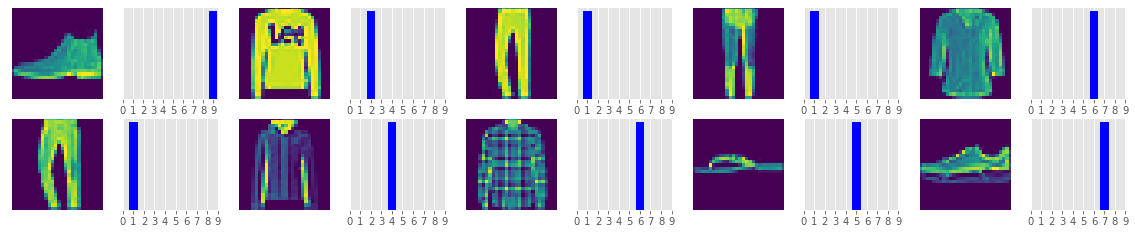

In [80]:
# Plot the first 10 test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
fig = plt.figure(figsize=(20,20))
rows = 10
columns = 10
a = 1
for i in range(10):
  fig.add_subplot(rows, columns,a)
  plt.imshow(test_images[i])
  plt.yticks([])
  plt.xticks([])
  a += 1
  fig.add_subplot(rows, columns,a)
  if arg[i] == test_labels[i]:
    plt.bar(range(test_labels[i],test_labels[i]+1), 1, color='blue')
    plt.yticks([])
    plt.xticks(range(10))
  else:
    plt.bar(range(test_labels[i],test_labels[i]+1), 1, color='red')
    plt.yticks([])
    plt.xticks(range(10))
  a += 1
plt.show()

## Use the trained model

Finally, use the trained model to make a prediction about a single image.

In [81]:
# Grab an image from the test dataset.
img = test_images[69]



`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. Accordingly, even though you're using a single image, you need to add it to a list:

In [82]:
# Add the image to a batch where it's the only member.
#hint: use np.expand_dims
#complete code below
img = np.expand_dims(img, axis=0)

print(img.shape)

(1, 28, 28)


Now predict the correct label for this image:

In [83]:
#complete code below
predictions_single = probability_model.predict(img)
arg_single = np.argmax(predictions_single, axis=1)
single_label = class_df.at[arg_single[0], 'Class']
print(single_label)

Bag


`tf.keras.Model.predict` returns a list of lists—one list for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [84]:
#print the predicted class for the image
model.predict(img)

array([[2.9137583e-08, 3.6606430e-12, 3.3384637e-07, 2.1353486e-08,
        6.6411481e-08, 3.7293635e-08, 1.2534692e-08, 1.0667400e-07,
        9.9999940e-01, 4.8598292e-10]], dtype=float32)

# Regularization
In mathematics, statistics, and computer science, particularly in machine learning and inverse problems, regularization is the process of adding information in order to solve an ill-posed problem or to prevent overfitting.

In order to improve the performance of the model, we use different regularization techniques. There are several techniques, but we will discuss 4 main techniques.

1. L1 Regularization
2. L2 Regularization
3. Dropout
4. Batch Normalization

In [85]:
#Basic pre-processing
#we're importing the iris dataset from sklearn for our model
from sklearn.datasets import load_iris
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
iris = load_iris()
X = iris.data
y = iris.target
y = to_categorical(y) #converting output to one-hot vector
ss = StandardScaler() #standardizing the data
X = ss.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=16)

In [86]:
#explore the data (X and y) however you like, (using info(), describe, graphs, etc.) and write any 4 lines on what you understood about the dataset
X_df = pd.DataFrame(X, columns = ['A','B','C','D'])
X_df.info()
print("\n*******************************************************************")
print(X_df.describe())
print("\n*******************************************************************")
y_df = pd.DataFrame(y, columns = ['A','B','C'])
y_df.info()
print("\n*******************************************************************")
y_df.describe()
#Solution can be anything

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       150 non-null    float64
 1   B       150 non-null    float64
 2   C       150 non-null    float64
 3   D       150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB

*******************************************************************
                  A             B             C             D
count  1.500000e+02  1.500000e+02  1.500000e+02  1.500000e+02
mean  -1.468455e-15 -1.823726e-15 -1.610564e-15 -9.473903e-16
std    1.003350e+00  1.003350e+00  1.003350e+00  1.003350e+00
min   -1.870024e+00 -2.433947e+00 -1.567576e+00 -1.447076e+00
25%   -9.006812e-01 -5.923730e-01 -1.226552e+00 -1.183812e+00
50%   -5.250608e-02 -1.319795e-01  3.364776e-01  1.325097e-01
75%    6.745011e-01  5.586108e-01  7.627583e-01  7.906707e-01
max    2.492019e+00  3.090775e+00  1.785832e+00  1.712096e+00

******

,A,B,C
count,150.000000,150.000000,150.000000
mean,0.333333,0.333333,0.333333
std,0.472984,0.472984,0.472984
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


And the model predicts a label as expected.

In [87]:
#model building

#run the code given below and observe the performance of this simple model having no regularization

model1 = Sequential([
    Dense(512, activation='tanh', input_shape = X_train[0].shape),
    Dense(512//2, activation='tanh'),
    Dense(512//4, activation='tanh'),
    Dense(512//8, activation='tanh'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])
print(model1.summary())
model1.compile(optimizer='sgd',loss='categorical_crossentropy', metrics=['acc', 'mse'])

hist1 = model1.fit(X_train, y_train, epochs=150, batch_size=128, validation_data=(X_test,y_test))


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 512)               2560      
_________________________________________________________________
dense_59 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_60 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_61 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_62 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_63 (Dense)             (None, 3)                 99        
Total params: 177,219
Trainable params: 177,219
Non-trainable params: 0
_______________________________________________

In [88]:
#After training the model, evaluate the model and find the  loss, accuracy and mse on the test set using the evaluate() function
#print the loss, accuracy and MSE

loss, acc, mse = model1.evaluate(X_test, y_test)
print("Loss is", loss)
print("Accuracy is", acc)
print("Mse is", mse)

2/2 [==============================] - 0s 2ms/step - loss: 0.3679 - acc: 0.8158 - mse: 0.0699
Loss is 0.36792635917663574
Accuracy is 0.8157894611358643
Mse is 0.06987392902374268


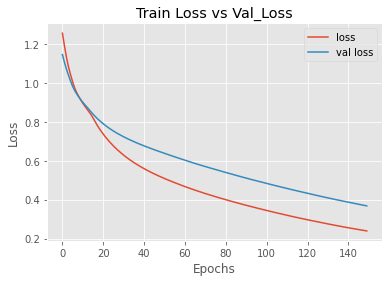

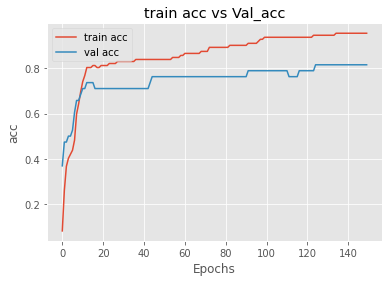

In [89]:
#Observe the plots for Validation Loss and Training Loss.

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.plot(hist1.history['loss'], label = 'loss')
plt.plot(hist1.history['val_loss'], label='val loss')
plt.title("Train Loss vs Val_Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# we observe that validation loss is increasing as compared to training loss. 
# This increase in training loss shows that our model is overfitted.

#similarly we plot for model accuracy 
plt.plot(hist1.history['acc'], label = 'train acc')
plt.plot(hist1.history['val_acc'], label='val acc')
plt.title("train acc vs Val_acc")
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.legend()
plt.show()

#This again shows that validation accuracy is low as compared to training accuracy, which again shows signs of overfitting. 




## L1 Regularization:
 


In [90]:

#A commonly used Regularization technique is L1 regularization, also known as Lasso Regularization.

#The main concept of L1 Regularization is that we have to penalize our weights by adding absolute values of weight in our loss function, multiplied by a regularization parameter lambda λ, where λ is manually tuned to be greater than 0.



#to implement L1 regularization, create another model called model2 similar to model1, this time add an extra parameter kernel_regularizer, which we set it to ‘l1’ for L1 Regularization in the first Dense layer:
lul =  X_train[0].shape
model_moj = Sequential()
model_moj.add(Dense(512, activation='tanh', input_shape = lul, kernel_regularizer='l1'))
model_moj.add(Dense(512//2, activation='tanh'))
model_moj.add(Dense(512//4, activation='tanh'))
model_moj.add(Dense(512//8, activation='tanh'))
model_moj.add(Dense(512//16, activation='relu'))
model_moj.add(Dense(3, activation="softmax"))

model_moj.compile(optimizer='sgd',loss='categorical_crossentropy', metrics=['accuracy', 'mse'])
hist2 = model_moj.fit(X_train, y_train, epochs=100, validation_data=(X_test,y_test))


Epoch 1/100
4/4 [==============================] - 1s 68ms/step - loss: 2.2163 - accuracy: 0.2411 - mse: 0.2244 - val_loss: 2.1493 - val_accuracy: 0.6053 - val_mse: 0.2103
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 2.0826 - accuracy: 0.6964 - mse: 0.1954 - val_loss: 2.0477 - val_accuracy: 0.6053 - val_mse: 0.1888
Epoch 3/100
4/4 [==============================] - 0s 16ms/step - loss: 1.9729 - accuracy: 0.7857 - mse: 0.1713 - val_loss: 1.9479 - val_accuracy: 0.6579 - val_mse: 0.1669
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 1.8724 - accuracy: 0.7946 - mse: 0.1489 - val_loss: 1.8624 - val_accuracy: 0.7105 - val_mse: 0.1486
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 1.7905 - accuracy: 0.8125 - mse: 0.1314 - val_loss: 1.7995 - val_accuracy: 0.7368 - val_mse: 0.1363
Epoch 6/100
4/4 [==============================] - 0s 14ms/step - loss: 1.7284 - accuracy: 0.8304 - mse: 0.1192 - val_loss: 1.7491 - val_acc

In [91]:


#just how we used evaluate() in the basic model previously, use it again to find the loss, accuracy and MSE on the test set

nuksan, accuracy, mse_moj = model_moj.evaluate(X_test, y_test)
print("Loss is ", nuksan)
print("Accuracy is", accuracy)
print("MSE is", mse_moj)


2/2 [==============================] - 0s 2ms/step - loss: 0.6589 - accuracy: 0.8947 - mse: 0.0319
Loss is  0.658926784992218
Accuracy is 0.8947368264198303
MSE is 0.0318792462348938


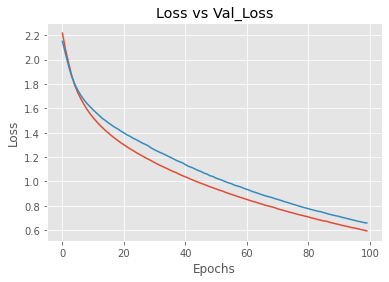

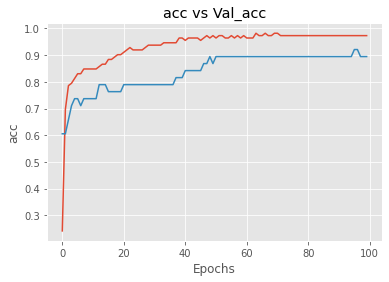

In [92]:
# Plot the train loss vs validation loss and train accuracy vs validation accuracy graphs just like we did before
# LUL Upr se likha. hehehehe

plt.plot(hist2.history['loss'], label = 'loss')
plt.plot(hist2.history['val_loss'], label='val loss')
plt.title("Loss vs Val_Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.plot(hist2.history['accuracy'], label = 'Accuracy')
plt.plot(hist2.history['val_accuracy'], label='Val Accuracy')
plt.title("acc vs Val_acc")
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.show()


 


In [93]:

# create a new model model3, similar to model1 and model2 and add l1 in more layers to check if it improves the model or not.

model3 = Sequential()
model3.add(Dense(512, activation='tanh', input_shape = lul , kernel_regularizer='l2'))
model3.add(Dense(512//2, activation='tanh', kernel_regularizer='l1'))
model3.add(Dense(512//4, activation='tanh', kernel_regularizer='l1'))
model3.add(Dense(512//8, activation='tanh', kernel_regularizer='l1'))
model3.add(Dense(32, activation='relu', kernel_regularizer='l1'))
model3.add(Dense(3, activation="softmax"))

model3.compile(optimizer='sgd',loss='categorical_crossentropy', metrics=['accuracy', 'mse'])
hist3 = model3.fit(X_train, y_train, epochs=100, validation_data=(X_test,y_test))



Epoch 1/100
4/4 [==============================] - 1s 62ms/step - loss: 89.3653 - accuracy: 0.4554 - mse: 0.2127 - val_loss: 88.8036 - val_accuracy: 0.6579 - val_mse: 0.1915
Epoch 2/100
4/4 [==============================] - 0s 13ms/step - loss: 88.5228 - accuracy: 0.7589 - mse: 0.1775 - val_loss: 88.0395 - val_accuracy: 0.6579 - val_mse: 0.1741
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 87.7383 - accuracy: 0.7857 - mse: 0.1546 - val_loss: 87.2917 - val_accuracy: 0.6842 - val_mse: 0.1603
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 86.9785 - accuracy: 0.8125 - mse: 0.1372 - val_loss: 86.5579 - val_accuracy: 0.6842 - val_mse: 0.1491
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 86.2400 - accuracy: 0.8125 - mse: 0.1243 - val_loss: 85.8384 - val_accuracy: 0.6579 - val_mse: 0.1407
Epoch 6/100
4/4 [==============================] - 0s 11ms/step - loss: 85.5187 - accuracy: 0.8304 - mse: 0.1150 - val_loss: 85.132

In [94]:

#just how we used evaluate() in the basic model previously, use it again to find the loss, accuracy and MSE on the test set


loss3, accuracy3, mse_3 = model3.evaluate(X_test, y_test)
print("Loss is ", loss3)
print("Accuracy is", accuracy3)
print("MSE is", mse_3)



2/2 [==============================] - 0s 3ms/step - loss: 33.9321 - accuracy: 0.8684 - mse: 0.0617
Loss is  33.93210983276367
Accuracy is 0.8684210777282715
MSE is 0.06170456483960152


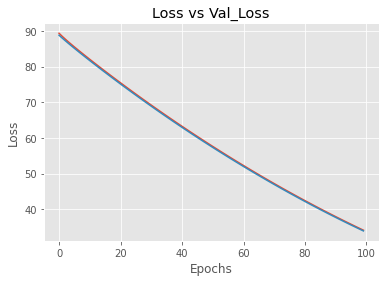

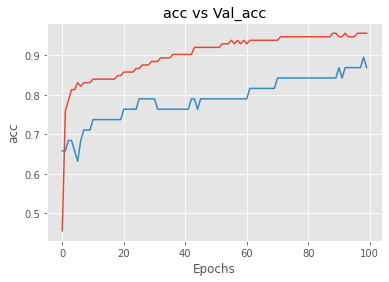

In [95]:
# Plot the train loss vs validation loss and train accuracy vs validation accuracy graphs just like we did before

plt.plot(hist3.history['loss'], label = 'loss')
plt.plot(hist3.history['val_loss'], label='val loss')
plt.title("Loss vs Val_Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.plot(hist3.history['accuracy'], label = 'Accuracy')
plt.plot(hist3.history['val_accuracy'], label='Val Accuracy')
plt.title("acc vs Val_acc")
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.show()




## L2 Regularization


In [96]:
 

# L2 Regularization is another regularization technique which is also known as Ridge regularization. In L2 regularization we add the squared magnitude of weights to penalize our lost function.

#to implement L2 regularization, create another model called model4 similar to our initial basic model, this time add an extra parameter kernel_regularizer, which we set to ‘l2’ for L1 Regularization in the first Dense layer.
#compile and run the model

model4 = Sequential()
model4.add(Dense(512, activation='tanh', input_shape = lul, kernel_regularizer='l2'))
model4.add(Dense(512//2, activation='tanh'))
model4.add(Dense(512//4, activation='tanh'))
model4.add(Dense(512//8, activation='tanh'))
model4.add(Dense(512//16, activation='relu'))
model4.add(Dense(3, activation="softmax"))

model4.compile(optimizer='sgd',loss='categorical_crossentropy', metrics=['accuracy', 'mse'])
hist4 = model4.fit(X_train, y_train, epochs=100, validation_data=(X_test,y_test))

 


Epoch 1/100
4/4 [==============================] - 1s 55ms/step - loss: 1.1979 - accuracy: 0.3929 - mse: 0.2259 - val_loss: 1.1164 - val_accuracy: 0.3947 - val_mse: 0.2086
Epoch 2/100
4/4 [==============================] - 0s 10ms/step - loss: 1.0460 - accuracy: 0.6875 - mse: 0.1921 - val_loss: 1.0236 - val_accuracy: 0.6579 - val_mse: 0.1874
Epoch 3/100
4/4 [==============================] - 0s 10ms/step - loss: 0.9471 - accuracy: 0.7679 - mse: 0.1687 - val_loss: 0.9410 - val_accuracy: 0.7105 - val_mse: 0.1682
Epoch 4/100
4/4 [==============================] - 0s 9ms/step - loss: 0.8558 - accuracy: 0.7857 - mse: 0.1471 - val_loss: 0.8732 - val_accuracy: 0.7368 - val_mse: 0.1527
Epoch 5/100
4/4 [==============================] - 0s 10ms/step - loss: 0.7823 - accuracy: 0.8036 - mse: 0.1299 - val_loss: 0.8187 - val_accuracy: 0.7105 - val_mse: 0.1406
Epoch 6/100
4/4 [==============================] - 0s 10ms/step - loss: 0.7226 - accuracy: 0.8036 - mse: 0.1164 - val_loss: 0.7722 - val_accu

In [97]:

#just how we used evaluate() in the basic model previously, use it again to find the loss, accuracy and MSE on the test set

loss4, accuracy4, mse_4 = model4.evaluate(X_test, y_test)
print("Loss is ", loss4)
print("Accuracy is", accuracy4)
print("MSE is", mse_4)


2/2 [==============================] - 0s 997us/step - loss: 0.2081 - accuracy: 0.8947 - mse: 0.0272
Loss is  0.20805144309997559
Accuracy is 0.8947368264198303
MSE is 0.027171442285180092


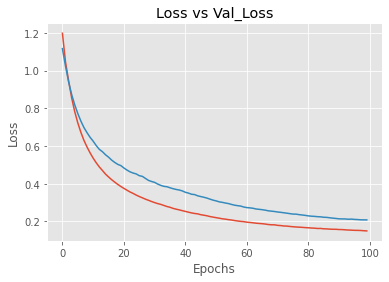

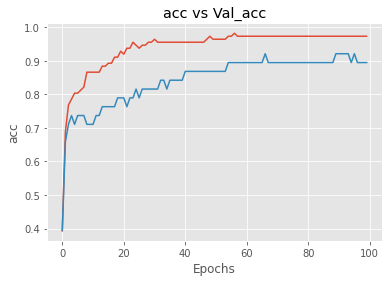

In [98]:

# Plot the train loss vs validation loss and train accuracy vs validation accuracy graphs just like we did before

plt.plot(hist4.history['loss'], label = 'loss')
plt.plot(hist4.history['val_loss'], label='val loss')
plt.title("Loss vs Val_Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.plot(hist4.history['accuracy'], label = 'Accuracy')
plt.plot(hist4.history['val_accuracy'], label='Val Accuracy')
plt.title("acc vs Val_acc")
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.show()


In [99]:

# Now create model5 having similar to the above models having L2 in all other layers.

model5 = Sequential()
model5.add(Dense(512, activation='tanh', input_shape = lul , kernel_regularizer='l2'))
model5.add(Dense(512//2, activation='tanh', kernel_regularizer='l2'))
model5.add(Dense(512//4, activation='tanh', kernel_regularizer='l2'))
model5.add(Dense(512//8, activation='tanh', kernel_regularizer='l2'))
model5.add(Dense(32, activation='relu', kernel_regularizer='l2'))
model5.add(Dense(3, activation="softmax"))

model5.compile(optimizer='sgd',loss='categorical_crossentropy', metrics=['accuracy', 'mse'])
hist5 = model5.fit(X_train, y_train, epochs=100, validation_data=(X_test,y_test))



Epoch 1/100
4/4 [==============================] - 1s 70ms/step - loss: 7.6213 - accuracy: 0.2411 - mse: 0.2248 - val_loss: 7.5328 - val_accuracy: 0.5526 - val_mse: 0.2058
Epoch 2/100
4/4 [==============================] - 0s 13ms/step - loss: 7.4464 - accuracy: 0.7232 - mse: 0.1860 - val_loss: 7.4251 - val_accuracy: 0.6579 - val_mse: 0.1821
Epoch 3/100
4/4 [==============================] - 0s 12ms/step - loss: 7.3182 - accuracy: 0.7500 - mse: 0.1571 - val_loss: 7.3295 - val_accuracy: 0.7105 - val_mse: 0.1614
Epoch 4/100
4/4 [==============================] - 0s 11ms/step - loss: 7.2161 - accuracy: 0.8125 - mse: 0.1348 - val_loss: 7.2571 - val_accuracy: 0.7368 - val_mse: 0.1471
Epoch 5/100
4/4 [==============================] - 0s 10ms/step - loss: 7.1396 - accuracy: 0.8393 - mse: 0.1194 - val_loss: 7.1954 - val_accuracy: 0.7632 - val_mse: 0.1358
Epoch 6/100
4/4 [==============================] - 0s 11ms/step - loss: 7.0778 - accuracy: 0.8393 - mse: 0.1079 - val_loss: 7.1471 - val_acc

In [100]:

#just how we used evaluate() in the basic model previously, use it again to find the loss, accuracy and MSE on the test set

loss5, accuracy5, mse_5 = model5.evaluate(X_test, y_test)
print("Loss is ", loss5)
print("Accuracy is", accuracy5)
print("MSE is", mse_5)


2/2 [==============================] - 0s 20ms/step - loss: 5.7684 - accuracy: 0.8947 - mse: 0.0323
Loss is  5.768421173095703
Accuracy is 0.8947368264198303
MSE is 0.032260991632938385


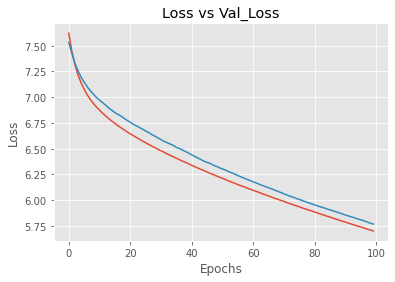

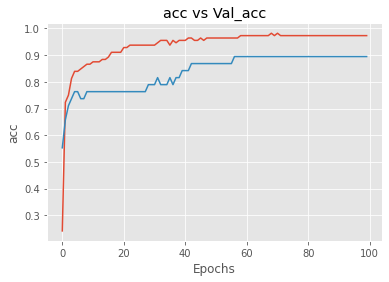

In [101]:
# Plot the train loss vs validation loss and train accuracy vs validation accuracy graphs just like we did before

plt.plot(hist5.history['loss'], label = 'loss')
plt.plot(hist5.history['val_loss'], label='val loss')
plt.title("Loss vs Val_Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.plot(hist5.history['accuracy'], label = 'Accuracy')
plt.plot(hist5.history['val_accuracy'], label='Val Accuracy')
plt.title("acc vs Val_acc")
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.show()



 

## Dropout
 


In [102]:

#Another common way to avoid regularization is by using the Dropout technique. The main idea behind using dropout is that we randomly turn off some neurons in our layer based on some probability.

# Create a model6 having same layers as the basic model. Add a dropout layer in this model, lets say after the 1st dense layer, and set dropout rate as 50%
import tensorflow as tf

model6 = Sequential()
model6.add(Dense(512, activation='tanh', input_shape = lul))
tf.keras.layers.Dropout(0.5)
model6.add(Dense(512//2, activation='tanh'))
model6.add(Dense(512//4, activation='tanh'))
model6.add(Dense(512//8, activation='tanh'))
model6.add(Dense(32, activation='relu'))
model6.add(Dense(3, activation='softmax'))

model6.compile(optimizer='sgd',loss='categorical_crossentropy', metrics=['acc', 'mse'])
hist6 = model6.fit(X_train, y_train, epochs=150, batch_size=128, validation_data=(X_test,y_test), verbose=2)



Epoch 1/150
1/1 - 0s - loss: 1.0866 - acc: 0.3393 - mse: 0.2200 - val_loss: 0.9979 - val_acc: 0.4474 - val_mse: 0.1995
Epoch 2/150
1/1 - 0s - loss: 1.0314 - acc: 0.4286 - mse: 0.2072 - val_loss: 0.9550 - val_acc: 0.5000 - val_mse: 0.1892
Epoch 3/150
1/1 - 0s - loss: 0.9835 - acc: 0.4375 - mse: 0.1959 - val_loss: 0.9181 - val_acc: 0.6579 - val_mse: 0.1803
Epoch 4/150
1/1 - 0s - loss: 0.9407 - acc: 0.5446 - mse: 0.1857 - val_loss: 0.8862 - val_acc: 0.7895 - val_mse: 0.1726
Epoch 5/150
1/1 - 0s - loss: 0.9026 - acc: 0.7500 - mse: 0.1767 - val_loss: 0.8589 - val_acc: 0.7895 - val_mse: 0.1660
Epoch 6/150
1/1 - 0s - loss: 0.8690 - acc: 0.8393 - mse: 0.1687 - val_loss: 0.8350 - val_acc: 0.7895 - val_mse: 0.1603
Epoch 7/150
1/1 - 0s - loss: 0.8391 - acc: 0.8750 - mse: 0.1617 - val_loss: 0.8152 - val_acc: 0.7895 - val_mse: 0.1557
Epoch 8/150
1/1 - 0s - loss: 0.8138 - acc: 0.8750 - mse: 0.1557 - val_loss: 0.7993 - val_acc: 0.7632 - val_mse: 0.1520
Epoch 9/150
1/1 - 0s - loss: 0.7926 - acc: 0.883

In [103]:
#just how we used evaluate() in the basic model previously, use it again to find the loss, accuracy and MSE on the test set

loss6, accuracy6, mse_6 = model6.evaluate(X_test, y_test)
print("Loss is ", loss6)
print("Accuracy is", accuracy6)
print("MSE is", mse_6)


2/2 [==============================] - 0s 8ms/step - loss: 0.3191 - acc: 0.8158 - mse: 0.0659
Loss is  0.3191084563732147
Accuracy is 0.8157894611358643
MSE is 0.06592100113630295


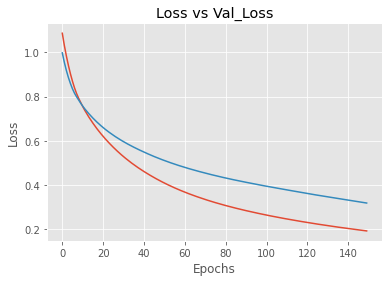

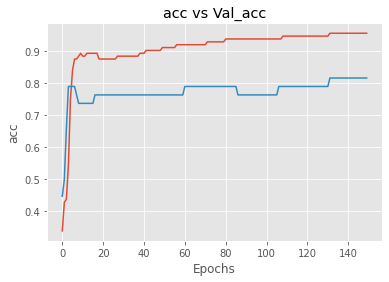

In [104]:

# Plot the train loss vs validation loss and train accuracy vs validation accuracy graphs just like we did before

plt.plot(hist6.history['loss'], label = 'loss')
plt.plot(hist6.history['val_loss'], label='val loss')
plt.title("Loss vs Val_Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.plot(hist6.history['acc'], label = 'ACC')
plt.plot(hist6.history['val_acc'], label='val acc')
plt.title("acc vs Val_acc")
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.show()


In [105]:
# Create model7, having more dropout layers, having a dropout rate of your choice


model7 = Sequential()
model7.add(Dense(512, activation='tanh', input_shape = lul))
tf.keras.layers.Dropout(0.5)
model7.add(Dense(512//2, activation='tanh'))
tf.keras.layers.Dropout(0.5)
model7.add(Dense(512//4, activation='tanh'))
tf.keras.layers.Dropout(0.5)
model7.add(Dense(512//8, activation='tanh'))
tf.keras.layers.Dropout(0.5)
model7.add(Dense(32, activation='relu'))
model7.add(Dense(3, activation='softmax'))

model7.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['acc', 'mse'])
hist7 = model7.fit(X_train, y_train, epochs=150, batch_size=128, validation_data=(X_test,y_test), verbose=2)



Epoch 1/150
1/1 - 1s - loss: 1.2080 - acc: 0.0625 - mse: 0.2457 - val_loss: 1.1427 - val_acc: 0.0789 - val_mse: 0.2319
Epoch 2/150
1/1 - 0s - loss: 1.1463 - acc: 0.1964 - mse: 0.2327 - val_loss: 1.0993 - val_acc: 0.3421 - val_mse: 0.2224
Epoch 3/150
1/1 - 0s - loss: 1.0898 - acc: 0.3750 - mse: 0.2203 - val_loss: 1.0639 - val_acc: 0.5526 - val_mse: 0.2144
Epoch 4/150
1/1 - 0s - loss: 1.0412 - acc: 0.6161 - mse: 0.2093 - val_loss: 1.0336 - val_acc: 0.6053 - val_mse: 0.2075
Epoch 5/150
1/1 - 0s - loss: 0.9995 - acc: 0.6786 - mse: 0.1996 - val_loss: 1.0063 - val_acc: 0.6053 - val_mse: 0.2012
Epoch 6/150
1/1 - 0s - loss: 0.9647 - acc: 0.6786 - mse: 0.1914 - val_loss: 0.9815 - val_acc: 0.6053 - val_mse: 0.1954
Epoch 7/150
1/1 - 0s - loss: 0.9331 - acc: 0.6786 - mse: 0.1838 - val_loss: 0.9584 - val_acc: 0.6053 - val_mse: 0.1900
Epoch 8/150
1/1 - 0s - loss: 0.9041 - acc: 0.6786 - mse: 0.1769 - val_loss: 0.9372 - val_acc: 0.6053 - val_mse: 0.1850
Epoch 9/150
1/1 - 0s - loss: 0.8773 - acc: 0.678

In [106]:
#just how we used evaluate() in the basic model previously, use it again to find the loss, accuracy and MSE on the test set


loss7, accuracy7, mse_7 = model7.evaluate(X_test, y_test)
print("Loss is ", loss7)
print("Accuracy is", accuracy7)
print("MSE is", mse_7)



2/2 [==============================] - 0s 2ms/step - loss: 0.3833 - acc: 0.8158 - mse: 0.0783
Loss is  0.38326209783554077
Accuracy is 0.8157894611358643
MSE is 0.0782579779624939


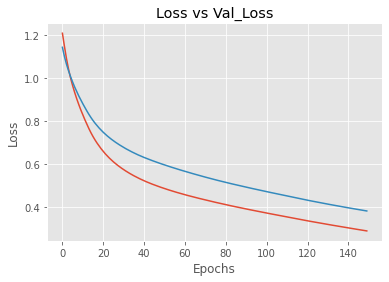

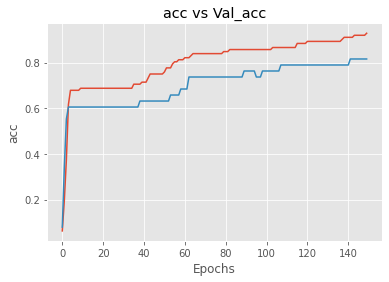

In [107]:
# Plot the train loss vs validation loss and train accuracy vs validation accuracy graphs just like we did before

plt.plot(hist7.history['loss'], label = 'loss')
plt.plot(hist7.history['val_loss'], label='val loss')
plt.title("Loss vs Val_Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.plot(hist7.history['acc'], label = 'ACC')
plt.plot(hist7.history['val_acc'], label='val acc')
plt.title("acc vs Val_acc")
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.show()


## Batch Normalization


In [108]:

# The main idea behind batch normalization is that we normalize the input layer by using several techniques (sklearn.preprocessing.StandardScaler) in our case, which improves the model performance, so if the input layer is benefitted by normalization, why not normalize the hidden layers, which will improve and fasten learning even further.

# To add it in your TensorFlow model, just add tf.keras.layers.BatchNormalization() after your layers.

#Create model8, having same layers as the first model, but this time add a BatchNormalization layer after the first or second dense layer


model8 = Sequential()
model8.add(Dense(512, activation='tanh', input_shape = lul))
tf.keras.layers.BatchNormalization()
model8.add(Dense(512//2, activation='tanh'))
model8.add(Dense(512//4, activation='tanh'))
model8.add(Dense(512//8, activation='tanh'))
model8.add(Dense(32, activation='relu'))
model8.add(Dense(3, activation='softmax'))

model8.compile(optimizer='sgd',loss='categorical_crossentropy', metrics=['acc', 'mse'])
hist8 = model8.fit(X_train, y_train, epochs=150, batch_size=128, validation_data=(X_test,y_test), verbose=2)


 


Epoch 1/150
1/1 - 1s - loss: 1.0457 - acc: 0.6071 - mse: 0.2104 - val_loss: 1.0189 - val_acc: 0.6316 - val_mse: 0.2039
Epoch 2/150
1/1 - 0s - loss: 1.0013 - acc: 0.6964 - mse: 0.2000 - val_loss: 0.9898 - val_acc: 0.6316 - val_mse: 0.1971
Epoch 3/150
1/1 - 0s - loss: 0.9626 - acc: 0.7411 - mse: 0.1908 - val_loss: 0.9634 - val_acc: 0.6579 - val_mse: 0.1909
Epoch 4/150
1/1 - 0s - loss: 0.9280 - acc: 0.7679 - mse: 0.1825 - val_loss: 0.9400 - val_acc: 0.6842 - val_mse: 0.1854
Epoch 5/150
1/1 - 0s - loss: 0.8972 - acc: 0.7589 - mse: 0.1751 - val_loss: 0.9182 - val_acc: 0.6842 - val_mse: 0.1803
Epoch 6/150
1/1 - 0s - loss: 0.8684 - acc: 0.7589 - mse: 0.1682 - val_loss: 0.8977 - val_acc: 0.6842 - val_mse: 0.1755
Epoch 7/150
1/1 - 0s - loss: 0.8419 - acc: 0.7589 - mse: 0.1618 - val_loss: 0.8787 - val_acc: 0.6579 - val_mse: 0.1711
Epoch 8/150
1/1 - 0s - loss: 0.8175 - acc: 0.7679 - mse: 0.1560 - val_loss: 0.8605 - val_acc: 0.6579 - val_mse: 0.1669
Epoch 9/150
1/1 - 0s - loss: 0.7946 - acc: 0.767

In [109]:
#just how we used evaluate() in the basic model previously, use it again to find the loss, accuracy and MSE on the test set

loss8, accuracy8, mse_8 = model8.evaluate(X_test, y_test)
print("Loss is ", loss8)
print("Accuracy is", accuracy8)
print("MSE is", mse_8)


2/2 [==============================] - 0s 2ms/step - loss: 0.3319 - acc: 0.8158 - mse: 0.0674
Loss is  0.3319091200828552
Accuracy is 0.8157894611358643
MSE is 0.06744123250246048


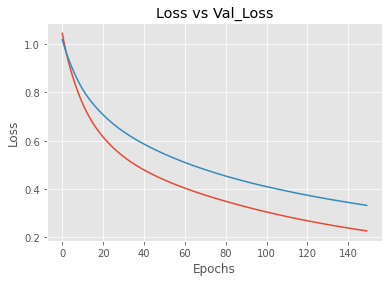

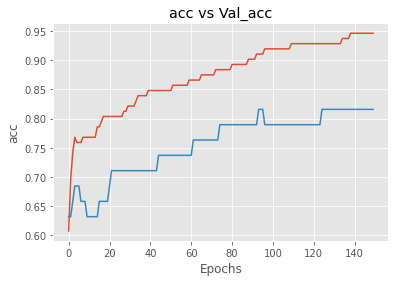

In [110]:
# Plot the train loss vs validation loss and train accuracy vs validation accuracy graphs just like we did before

plt.plot(hist8.history['loss'], label = 'loss')
plt.plot(hist8.history['val_loss'], label='val loss')
plt.title("Loss vs Val_Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


plt.plot(hist8.history['acc'], label = 'ACC')
plt.plot(hist8.history['val_acc'], label='val acc')
plt.title("acc vs Val_acc")
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.show()



In [111]:

# Now create model9, having a BatchNormalization layer after each dense layer


model9 = Sequential()
model9.add(Dense(512, activation='tanh', input_shape = lul))
tf.keras.layers.BatchNormalization()
model9.add(Dense(512//2, activation='tanh'))
tf.keras.layers.BatchNormalization()
model9.add(Dense(512//4, activation='tanh'))
tf.keras.layers.BatchNormalization()
model9.add(Dense(512//8, activation='tanh'))
tf.keras.layers.BatchNormalization()
model9.add(Dense(32, activation='relu'))
tf.keras.layers.BatchNormalization()
model9.add(Dense(3, activation='softmax'))

model9.compile(optimizer='sgd',loss='categorical_crossentropy', metrics=['acc', 'mse'])
hist9 = model9.fit(X_train, y_train, epochs=150, batch_size=128, validation_data=(X_test,y_test), verbose=2)





Epoch 1/150
1/1 - 1s - loss: 1.2104 - acc: 0.0357 - mse: 0.2467 - val_loss: 1.1328 - val_acc: 0.0526 - val_mse: 0.2300
Epoch 2/150
1/1 - 0s - loss: 1.1395 - acc: 0.1250 - mse: 0.2313 - val_loss: 1.0830 - val_acc: 0.3421 - val_mse: 0.2190
Epoch 3/150
1/1 - 0s - loss: 1.0820 - acc: 0.3661 - mse: 0.2187 - val_loss: 1.0401 - val_acc: 0.6579 - val_mse: 0.2094
Epoch 4/150
1/1 - 0s - loss: 1.0329 - acc: 0.7143 - mse: 0.2078 - val_loss: 1.0022 - val_acc: 0.7632 - val_mse: 0.2008
Epoch 5/150
1/1 - 0s - loss: 0.9900 - acc: 0.7857 - mse: 0.1981 - val_loss: 0.9680 - val_acc: 0.7368 - val_mse: 0.1929
Epoch 6/150
1/1 - 0s - loss: 0.9532 - acc: 0.7946 - mse: 0.1895 - val_loss: 0.9363 - val_acc: 0.7368 - val_mse: 0.1853
Epoch 7/150
1/1 - 0s - loss: 0.9189 - acc: 0.8214 - mse: 0.1814 - val_loss: 0.9063 - val_acc: 0.7368 - val_mse: 0.1781
Epoch 8/150
1/1 - 0s - loss: 0.8868 - acc: 0.8304 - mse: 0.1737 - val_loss: 0.8778 - val_acc: 0.7368 - val_mse: 0.1713
Epoch 9/150
1/1 - 0s - loss: 0.8565 - acc: 0.848

In [112]:
#just how we used evaluate() in the basic model previously, use it again to find the loss, accuracy and MSE on the test set

loss9, accuracy9, mse_9 = model9.evaluate(X_test, y_test)
print("Loss is ", loss9)
print("Accuracy is", accuracy9)
print("MSE is", mse_9)
 

2/2 [==============================] - 0s 2ms/step - loss: 0.3309 - acc: 0.8158 - mse: 0.0706
Loss is  0.33088552951812744
Accuracy is 0.8157894611358643
MSE is 0.07060638070106506


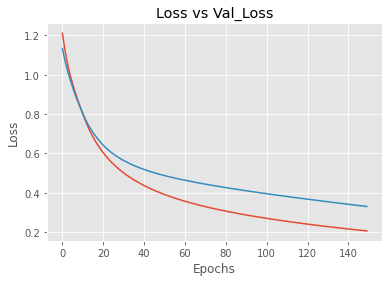

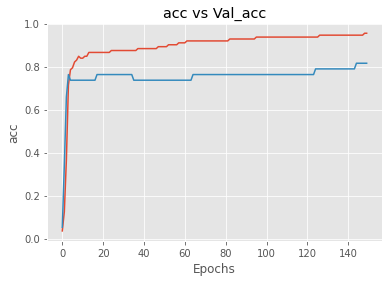

In [113]:
# Plot the train loss vs validation loss and train accuracy vs validation accuracy graphs just like we did before

plt.plot(hist9.history['loss'], label = 'loss')
plt.plot(hist9.history['val_loss'], label='val loss')
plt.title("Loss vs Val_Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.plot(hist9.history['acc'], label = 'ACC')
plt.plot(hist9.history['val_acc'], label='val acc')
plt.title("acc vs Val_acc")
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.show()


In [ ]:
#After completing the above tasks, note down what you've understood and observed in each of the 9 models and what type of regularization works best for this dataset


Judging from Loss, Accuracy and Mean square Error, i think Model 4 perform better compared to other models because accuracy is quite good and loss as well as mse.